In [1]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets

import random

from typing import List, Dict, Tuple, Callable

In [2]:
device = torch.device("cuda")
device

device(type='cuda')

In [3]:
INPUT_SIZE = (224, 224)

In [4]:
dataset_dir = "intel_places_ds"

In [5]:
def get_classes(path: str) -> Dict:
    classes = os.listdir(os.path.join(path, "seg_train/seg_train"))
    classes = {index: cls for index, cls in enumerate(classes)}
    return classes

classes = get_classes(dataset_dir)
classes

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [6]:
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ]),
    "test": transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
}

In [7]:
batch_train = 64
batch_test = 32
shuffle = True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class:  glacier


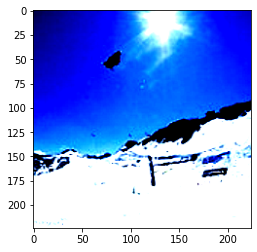

In [8]:
train_data = datasets.ImageFolder(root=os.path.join(dataset_dir, "seg_train/seg_train"), transform=data_transforms["train"])
test_data = datasets.ImageFolder(root=os.path.join(dataset_dir, "seg_test/seg_test"), transform=data_transforms["test"])

im, label = train_data[random.randint(0, len(train_data))]

print("Class: ", classes[label])
plt.imshow(im.permute(1,2,0).cpu())
plt.show()

dataloaders = {
    "train": DataLoader(train_data, batch_size=batch_train, shuffle=shuffle, drop_last=True),
    "test": DataLoader(test_data, batch_size=batch_test, shuffle=shuffle, drop_last=True),
}

In [9]:
feature_extracting = True
input_shape = (3, 224, 224)

In [10]:
from torchsummary import summary

def load_model(num_classes: int, feature_extracting: bool) -> Tuple:
    model = torchvision.models.resnet152(pretrained=True)

    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

    num_fltrs = model.fc.in_features


    model.fc = nn.Sequential(nn.Flatten(),
                             nn.Linear(num_fltrs, 128),
                             nn.ReLU(),
                             nn.Linear(128, num_classes),
                             nn.Softmax(dim=1))


    criter = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=0.001)

    return model.to(device), criter, opt

model, criterion, optimizer = load_model(len(classes), feature_extracting)

summary(model, input_shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [11]:
def train_batch(X: torch.Tensor,
                y: torch.Tensor,
                model: nn.Module,
                criter: Callable[[torch.Tensor, torch.Tensor], float],
                optimizer:  optim.Optimizer) -> float:

    output = model(X)

    loss = criter(output, y)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    return loss.item()


# @torch.no_grad()
def accuracy(X: torch.Tensor, y: torch.Tensor, model: nn.Module) -> List:
    model.eval()
    output = model(X)
    _, preds = torch.max(output, dim=1)
    correct = (preds == y).float().sum()
    return correct.item()

In [12]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

fc.1.weight
fc.1.bias
fc.3.weight
fc.3.bias


In [13]:
epochs = 3

In [14]:
def train_model(model: nn.Module,
                dataloaders: Dict[str, DataLoader],
                epochs: int,
                criter: Callable[[torch.Tensor, torch.Tensor], float],
                optimizer: optim.Optimizer) -> Tuple:

    train_acc, train_loss = [], []
    test_acc = []

    for epoch in range(epochs):
        print("Epoch {} / {}: ".format(epoch + 1, epochs))
        for phase in ["train", "test"]:
            print("Phase: ", phase)
            current_loss = 0
            current_correct = 0

            if phase == "train":
                model.train()
                for batch, (X, y) in enumerate(dataloaders[phase]):
                    
                    X, y = X.to(device), y.to(device)

                    batch_loss = train_batch(X, y, model, criter, optimizer)
                    correct = accuracy(X, y, model)

                    current_loss += batch_loss
                    current_correct += correct
                    

                epoch_loss = current_loss / len(dataloaders[phase])
                print(current_correct)
                epoch_acc = current_correct / len(train_data)

                
                print("Loss: {:.3f}, Accuracy: {:.3f}".format(epoch_loss, epoch_acc))

                train_acc.append(epoch_acc)
                train_loss.append(epoch_loss)

            if phase == "test":
            
                with torch.no_grad():
                    for X, y in dataloaders[phase]:
                     
                        X, y = X.to(device), y.to(device)
                        
                        correct = accuracy(X, y, model)

                        current_correct += correct

                    epoch_acc = current_correct / len(test_data)


                    print("Accuracy: {:.3f}".format(epoch_acc))
                    
                    test_acc.append(epoch_acc)


    torch.save(model, "models/NaturalScenesModel.pt")
    return train_acc, train_loss, test_acc


train_acc, train_loss, test_acc = train_model(model, dataloaders, epochs, criterion, optimizer)

Epoch 1 / 3: 
Phase:  train
12397.0
Loss: 1.185, Accuracy: 0.883
Phase:  test
Accuracy: 0.907
Epoch 2 / 3: 
Phase:  train
12937.0
Loss: 1.131, Accuracy: 0.922
Phase:  test
Accuracy: 0.907
Epoch 3 / 3: 
Phase:  train
13035.0
Loss: 1.122, Accuracy: 0.929
Phase:  test
Accuracy: 0.904


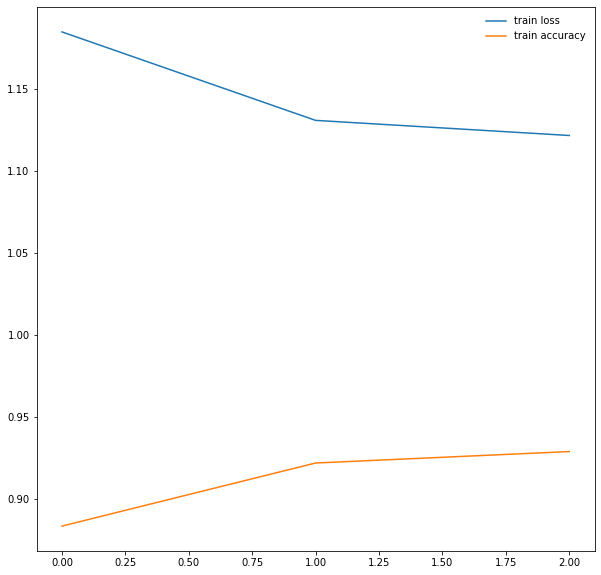

In [15]:
fig = plt.figure(figsize=(10, 10))
plt.plot(train_loss, label="train loss")
plt.plot(train_acc, label="train accuracy")
plt.legend(frameon = False)
plt.show()

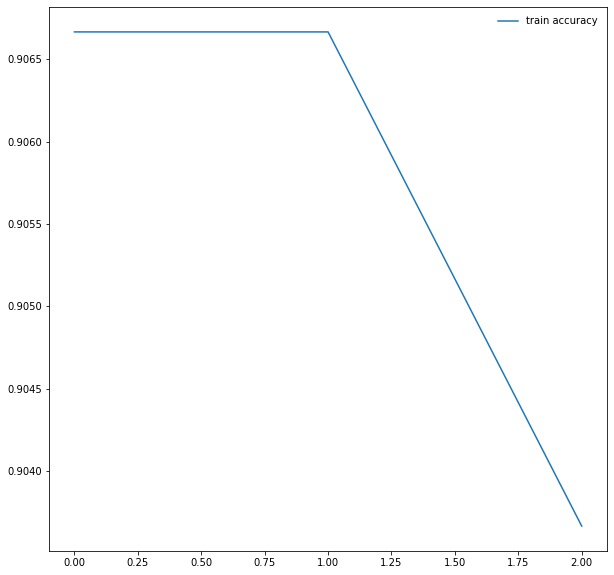

In [16]:
fig = plt.figure(figsize=(10, 10))
plt.plot(test_acc, label="train accuracy")
plt.legend(frameon = False)
plt.show()

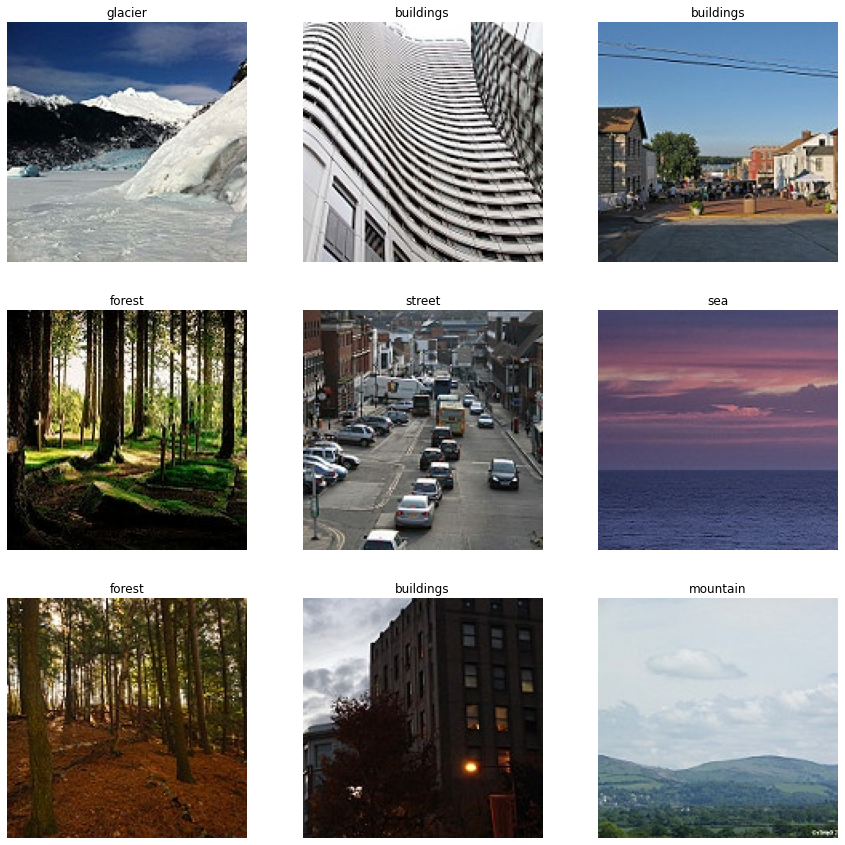

In [17]:
def predict(img: Image) -> int:
    from torch.autograd import Variable

    img = data_transforms["test"](img)
    img = img.unsqueeze(0).cuda()
    img = Variable(img).to(device)

    pred = model(img)
    cls = pred.data.cpu().numpy().argmax()
    return cls


def predict_k_images(imgs_paths: List, size: int) -> None:
    fig = plt.figure(figsize=(15, 15))

    imgs = random.sample(imgs_paths, size * size)

    for i in range(size * size):
        img = Image.open(imgs[i])
        index = predict(img)
        plt.subplot(size, size, i+1)
        plt.title(classes[index])
        plt.axis('off')
        plt.imshow(img)


model = torch.load("models/NaturalScenesModel.pt")
model.eval()

images_dir = "intel_places_ds/seg_pred/seg_pred"
pred_images = [os.path.join(images_dir, f) for f in os.listdir(images_dir)]

predict_k_images(pred_images, 3)

In [18]:
test_dir = "intel_places_ds/seg_test/seg_test"

all_folders = {f:os.path.join(test_dir, f) for f in os.listdir(test_dir)}
all_folders

{'buildings': 'intel_places_ds/seg_test/seg_test\\buildings',
 'forest': 'intel_places_ds/seg_test/seg_test\\forest',
 'glacier': 'intel_places_ds/seg_test/seg_test\\glacier',
 'mountain': 'intel_places_ds/seg_test/seg_test\\mountain',
 'sea': 'intel_places_ds/seg_test/seg_test\\sea',
 'street': 'intel_places_ds/seg_test/seg_test\\street'}

In [19]:
predictions_classes = {cls: np.array([]) for cls in all_folders.keys()}


def get_all_predictions(cls: str) -> np.ndarray:
    path = os.path.join(test_dir, cls)
    imgs = [os.path.join(path, f) for f in os.listdir(path)]

    preds = []
    for img in imgs:
        img = Image.open(img)
        preds.append(predict(img))

    return np.array(preds)

for k in predictions_classes.keys():
    predictions_classes[k] = get_all_predictions(k)

In [20]:
predictions_classes

{'buildings': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 5, 5, 0,
        5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0,
        0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0,

In [21]:
predictions_list = np.array([])
for v in predictions_classes.values():
    predictions_list = np.append(predictions_list, v)

predictions_list.shape

(3000,)

In [22]:
reverse_classes = {v: k for k, v in classes.items()}
reverse_classes

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [23]:
true_labels = np.array([])

for cls in all_folders.keys():
    d = os.path.join(test_dir, cls)
    labels = [reverse_classes[cls] for f in os.listdir(d)]
    true_labels = np.append(true_labels, labels)

true_labels.shape

(3000,)

In [24]:
from sklearn.metrics import classification_report

print(classification_report(predictions_list, true_labels, target_names=list(reverse_classes.keys())))

              precision    recall  f1-score   support

   buildings       0.93      0.91      0.92       450
      forest       1.00      0.99      0.99       478
     glacier       0.79      0.90      0.84       486
    mountain       0.92      0.79      0.85       611
         sea       0.92      0.99      0.95       477
      street       0.93      0.93      0.93       498

    accuracy                           0.91      3000
   macro avg       0.91      0.92      0.91      3000
weighted avg       0.91      0.91      0.91      3000



<AxesSubplot:>

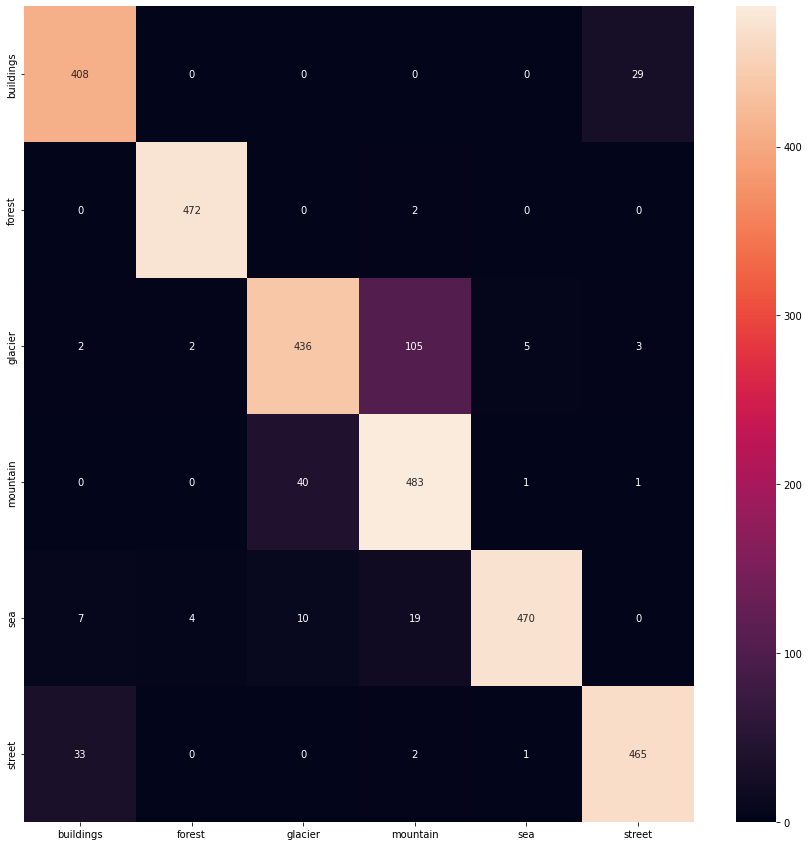

In [25]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

confusion = confusion_matrix(true_labels, predictions_list)

fig = plt.figure(figsize=(15, 15))
heatmap(confusion,
        annot=True,
        fmt="d",
        xticklabels=list(reverse_classes.keys()),
        yticklabels=list(reverse_classes.keys()))

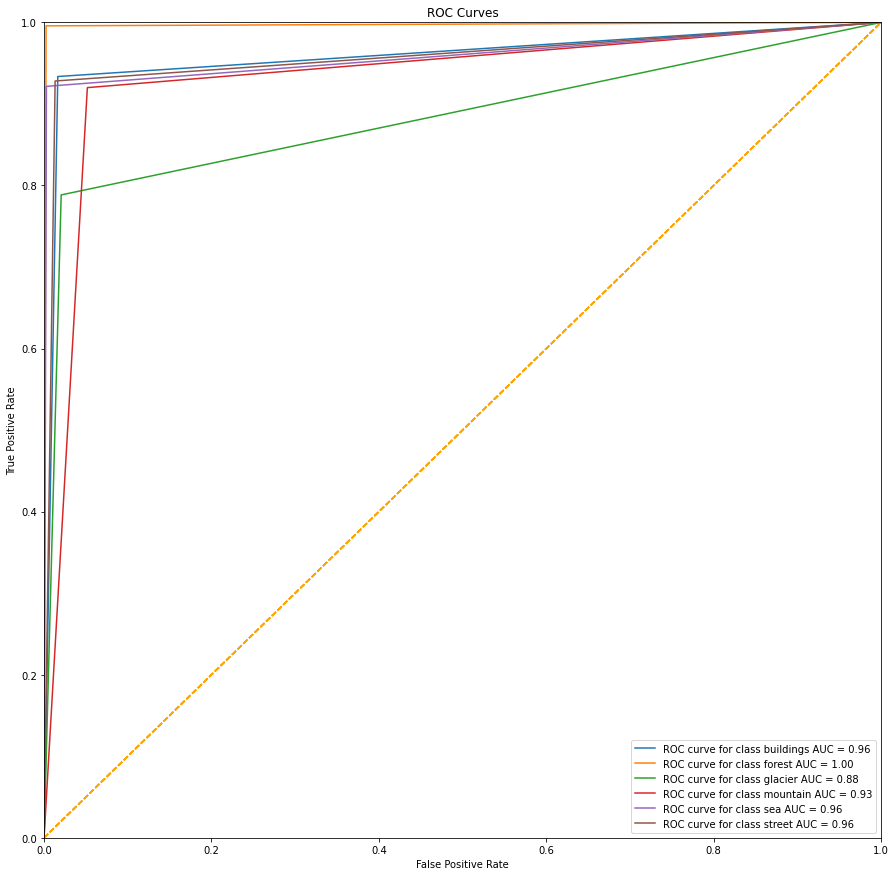

In [26]:
from sklearn.metrics import roc_curve, auc

fig = plt.figure(figsize=(15, 15))

def plot_roc_curves(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    true_for_class = [(y_true == float(i)) for i in list(classes.keys())]
    pred_for_class = [(y_pred == float(i)) for i in list(classes.keys())]
    
    fpr_tpr = [roc_curve(true_for_class[i], pred_for_class[i]) for i in list(classes.keys())]
    roc_auc = [auc(fpr_tpr[i][0], fpr_tpr[i][1]) for i in list(classes.keys())]
    
    plt.title("ROC Curves")
    
    for i in list(classes.keys()):
        plt.plot(fpr_tpr[i][0], fpr_tpr[i][1], label="ROC curve for class {} AUC = {:0.2f}".format(classes[i], roc_auc[i]))
        plt.legend(loc="lower right")
        plt.plot([0,1], [0,1], color='orange', linestyle='--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel("True Positive Rate")
        plt.xlabel("False Positive Rate")

    plt.show()
        

plot_roc_curves(true_labels, predictions_list)